# 라이브러리 불러오기

In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from surprise import Reader, Dataset, SVD
from surprise.model_selection import cross_validate

# 한글 폰트 활성화

In [2]:
def get_font_family():
    """
    시스템 환경에 따른 기본 폰트명을 반환하는 함수
    """
    import platform
    system_name = platform.system()

    if system_name == "Darwin" :
        font_family = "AppleGothic"
    elif system_name == "Windows":
        font_family = "Malgun Gothic"
    else:
        # Linux(colab)
        !apt-get install fonts-nanum -qq  > /dev/null
        !fc-cache -fv

        import matplotlib as mpl
        mpl.font_manager._rebuild()
        findfont = mpl.font_manager.fontManager.findfont
        mpl.font_manager.findfont = findfont
        mpl.backends.backend_agg.findfont = findfont
        
        font_family = "NanumBarunGothic"
    return font_family


# style 설정은 꼭 폰트설정 위에서 합니다.
# style 에 폰트 설정이 들어있으면 한글폰트가 초기화 되어 한글이 깨집니다.
plt.style.use("seaborn")
# 폰트설정
plt.rc("font", family=get_font_family())

# 마이너스폰트 설정
plt.rc("axes", unicode_minus=False)

# 그래프에 retina display 적용
%config InlineBackend.figure_format = 'retina'

# 데이터 로드

In [104]:
from kmr_dataset import load_rates
from kmr_dataset import get_paths

paths = get_paths(size='5m')
# paths = get_paths(size='2m')
# rates, timestamps = load_rates(size='small')
rates, timestamps = load_rates(size='5m')
import pandas as pd
castings, countries, genres, movies, peoples, rates = [pd.read_csv(path, delimiter = delim) for path, delim in zip(paths, [None] * 3 +['\t'] * 2 + [None])]

skip 87439 lines which are duplicated (user, item), #uniques=4943613


In [392]:
print(castings.shape, countries.shape, genres.shape, movies.shape, peoples.shape, rates.shape)

(819743, 4) (193783, 2) (197624, 1) (180982, 4) (263438, 3) (5031052, 4)


In [4]:
from kmr_dataset import load_histories

histories = load_histories(size='5m')

Unzipped rates-5m.zip


# EDA 및 concat

In [9]:
# 하나의 dataframe으로 합치기 위해 각 데이터에 어떤 column들이 있는지 확인한다
def check_scheme(df_names):
    df_list = [globals()[name] for name in df_names]
    whole_columns = []
    for df in df_list:
        whole_columns.extend(df.columns.tolist())
        whole_columns = list(set(whole_columns))
        tbl_rel = pd.DataFrame(index = whole_columns, columns = df_names)
        for idx, col in enumerate(tbl_rel.columns):
            for row in tbl_rel.index:
                tbl_rel.loc[row, col] = row in df_list[idx]
    return tbl_rel.astype(int).style.background_gradient(cmap = "Blues")

check_scheme(["castings", "countries", "genres", "movies", "peoples", "rates"])

,castings,countries,genres,movies,peoples,rates
time,0,0,0,0,0,1
user,0,0,0,0,0,1
rate,0,0,0,0,0,1
people,1,0,0,0,1,0
grade,0,0,0,1,0,0
country,0,1,0,0,0,0
order,1,0,0,0,0,0
title,0,0,0,1,0,0
leading,1,0,0,0,0,0
year,0,0,0,1,0,0


In [388]:
rates = pd.read_csv('./kmr_dataset/datafile/kmrd/rates-5m.csv')

In [389]:
cnt_user = rates.groupby("user").count()
cnt_user = cnt_user.groupby("movie").rate.count()
cnt_user.describe()

count     988.000000
mean       87.507085
std       438.240984
min         1.000000
25%         1.000000
50%         2.000000
75%        11.000000
max      5777.000000
Name: rate, dtype: float64

In [390]:
tmp = cnt_user[cnt_user.index >= 100]
cnt_user = cnt_user[cnt_user.index < 100]
cnt_user["100+"] = tmp.sum()
cnt_user

movie
20      5777
21      5144
22      4551
23      4132
24      3796
        ... 
96       138
97       140
98       116
99       135
100+    8374
Name: rate, Length: 81, dtype: int64

유저들이 후기를 얼만큼 작성했는지 시각화해보았다.<br>
최소 후기 작성 횟수는 20회로 추천시스템에서 발생할 수 있는 cold start는 없을 것으로 보인다.<br>
20회가 가장 많고 이후 점차 줄어듦에도 불구하고 100회 이상 작성한 유저가 상당히 많다는 것을 알 수 있다.

C:\Users\yr\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


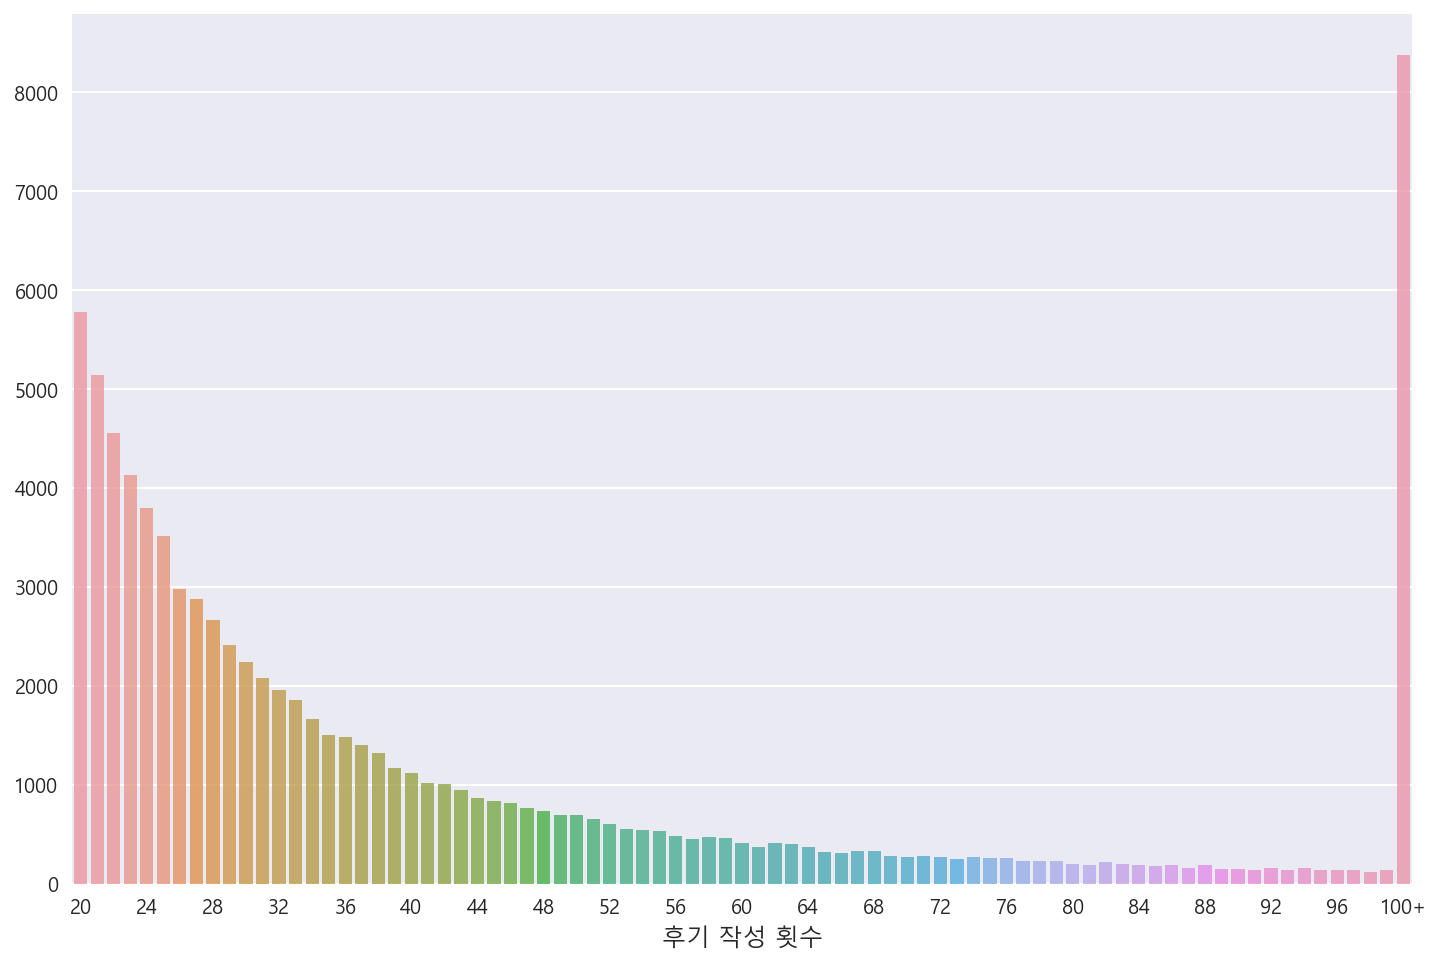

In [391]:
plt.figure(figsize=(12,8))
sns.barplot(cnt_user.index, cnt_user.values, alpha=0.8)
plt.xlabel('후기 작성 횟수', fontsize=12)
plt.xticks(np.arange(0,81,4))
plt.show()

In [18]:
# 최대 작성한 유저는 9990회 후기를 작성하였다. 개인이 아니라 단체가 아닐까싶다.
tmp.index.max()

9990

In [19]:
castings.shape, countries.shape, genres.shape, movies.shape, peoples.shape, rates.shape

((819743, 4), (193783, 2), (197624, 2), (180982, 5), (263438, 3), (5031052, 4))

## Model1
### 장르 조합별로 분류

장르 조합별로 분류를 하였더니 기존의 26개 분류에서 1636개로 분류가 늘어나 학습이 제대로 되지 않았다. 따라서 이 모델은 사용하지 않기로 했다.

In [20]:
castings = castings.groupby("movie").agg({"people" : lambda x : list(x), "order" : lambda x : list(x), "leading" : lambda x : list(x)})
print(castings.index.nunique())
castings.head()

108816


,people,order,leading
movie,,,
10001,"[4374, 178, 3241, 47952, 47953, 19538, 18991, ...","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","[1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]"
10002,"[1076, 4603, 917, 8637, 5104, 9986, 7470, 9987]","[1, 2, 3, 4, 5, 6, 7, 8]","[1, 1, 1, 1, 1, 0, 0, 0]"
10003,"[1076, 4603, 917, 5104, 391, 5106, 5105, 5107,...","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]","[1, 1, 0, 0, 0, 0, 0, 0, 0, 0]"
10004,"[1076, 4603, 1031, 5104, 10001, 5984, 10002, 1...","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]","[1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0]"
10005,"[1007, 535, 215, 1236, 35]","[1, 2, 3, 4, 5]","[1, 1, 1, 0, 0]"


In [23]:
countries = countries.groupby("movie").agg({"country" : lambda x : '/'.join(x)})
print(countries.index.nunique())
countries.head()

171166


,country
movie,
10001,이탈리아/프랑스
10002,미국
10003,미국
10004,미국
10005,미국


In [107]:
genre_index = genres.genre.unique()
len(genre_index)

26

In [21]:
# genres = genres.groupby("movie").agg({"genre" : lambda x : '/'.join(x)})
# print(genres.index.nunique())
# genres.head()

genres.set_index("movie")

129090


,genre
movie,
10001,드라마/멜로/로맨스
10002,SF/코미디
10003,SF/코미디
10004,서부/SF/판타지/코미디
10005,판타지/모험/SF/액션


In [179]:
movies = movies.set_index("movie")
movie_infos = movies.join(genres).join(countries).join(castings)
movie_infos.head()

,title,title_eng,year,grade,movie,genre
movie,,,,,,
10001,시네마 천국,"Cinema Paradiso , 1988",1990,전체 관람가,16884,드라마
10002,빽 투 더 퓨쳐,"Back To The Future , 1985",1987,12세 관람가,16884,전쟁
10003,빽 투 더 퓨쳐 2,"Back To The Future Part 2 , 1989",1990,12세 관람가,16885,드라마
10004,빽 투 더 퓨쳐 3,"Back To The Future Part III , 1990",1990,전체 관람가,16885,코미디
10005,스타워즈 에피소드 4 - 새로운 희망,"Star Wars , 1977",1978,PG,16886,멜로/로맨스


In [122]:
rates = rates.drop_duplicates()
rates = rates.groupby(["user", "movie"])[["rate"]].mean().reset_index("user")
df = rates.join(movie_infos)

In [123]:
df.head()

,user,rate,title,title_eng,year,grade,genre,country,people,order,leading
movie,,,,,,,,,,,
10001,2,7.0,시네마 천국,"Cinema Paradiso , 1988",1990,전체 관람가,드라마/멜로/로맨스,이탈리아/프랑스,"[4374, 178, 3241, 47952, 47953, 19538, 18991, ...","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","[1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]"
10001,3,10.0,시네마 천국,"Cinema Paradiso , 1988",1990,전체 관람가,드라마/멜로/로맨스,이탈리아/프랑스,"[4374, 178, 3241, 47952, 47953, 19538, 18991, ...","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","[1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]"
10001,4,5.0,시네마 천국,"Cinema Paradiso , 1988",1990,전체 관람가,드라마/멜로/로맨스,이탈리아/프랑스,"[4374, 178, 3241, 47952, 47953, 19538, 18991, ...","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","[1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]"
10001,8,10.0,시네마 천국,"Cinema Paradiso , 1988",1990,전체 관람가,드라마/멜로/로맨스,이탈리아/프랑스,"[4374, 178, 3241, 47952, 47953, 19538, 18991, ...","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","[1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]"
10001,10,9.0,시네마 천국,"Cinema Paradiso , 1988",1990,전체 관람가,드라마/멜로/로맨스,이탈리아/프랑스,"[4374, 178, 3241, 47952, 47953, 19538, 18991, ...","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","[1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]"


영화 제목이 없는 경우 제거해준다

In [124]:
# 한국제목과 영어제목이 모두 없는 영화의 id를 확인해본다
noname_movie = df[df.title.isnull() & df.title_eng.isnull()].index.unique()
noname_movie

Int64Index([ 10327,  10475,  10672,  10707,  10793,  10990,  11024,  11671,
             12149,  12196,
            ...
            145308, 145339, 147312, 147387, 149543, 149624, 149640, 160032,
            160969, 191237],
           dtype='int64', name='movie', length=722)

아래의 코드 결과 아무런 영화 id가 반환되지 않았다.<br>
즉 영화제목이 존재하는데 특정 열에서만 작성이 된 경우가 없다는 뜻이다.<br>
따라서 한글제목과 영어제목 모두 없는 경우 삭제해주었다.

In [166]:
tmp_series = pd.Series()
for movie in noname_movie:
    #해당 영화 후기가 하나뿐이면 float형으로 불러와서 isnull()에서 오류가 발생하므로 예외처리한다
    if type(df.loc[movie]) == type(tmp_series):
        if df.loc[movie][['title','title_eng']].isnull().sum():
            df.drop(movie, axis=0)
    elif df.loc[movie].title.notnull().sum() + df.loc[movie].title_eng.notnull().sum() != 0:
        print(movie)

C:\Users\yr\AppData\Local\Temp/ipykernel_11248/3644255775.py:1: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  tmp_series = pd.Series()


In [127]:
df = df.dropna(how='all', subset=['title','title_eng'])
df.isnull().sum()

user              0
rate              0
title         25855
title_eng     27122
year             36
grade        146700
genre         73037
country       28718
people        48108
order         48108
leading       48108
dtype: int64

In [85]:
# genre를 분류하기 위해 필요한 값만 불러와 dataframe을 만든다
df_genre = df[["user", "title", "title_eng", "genre", "rate"]]
df_genre.sample(5)

,user,title,title_eng,genre,rate
movie,,,,,
83098,40445,페이스 메이커,"pace maker , 2012",드라마,9.0
96961,16827,집으로 가는 길,"Way Back Home , 2013",드라마,5.0
38281,6440,에이리언 VS. 프레데터,"AVP: Alien Vs. Predator , 2004",액션/SF/모험/스릴러/공포/전쟁,5.0
41705,67642,한반도,"Hanbando , 2006",드라마/액션/스릴러,4.0
38662,66454,내 머리 속의 지우개,"A Moment To Remember , 2004",드라마/멜로/로맨스/코미디,8.0


In [168]:
# rating scale을 정하기전 이상치가 있는지 확인하기 위해 min max 확인
print(df.rate.min(), df.rate.max())

0.0 10.0


In [86]:
reader = Reader(rating_scale=(0, 10))

data = Dataset.load_from_df(df_genre[["user", "genre", "rate"]], reader)

svd = SVD()
cross_validate(svd, data, measures=['RMSE', 'MAE'])

{'test_rmse': array([3.09519041, 3.07889316, 3.09052431, 3.08348513, 3.08740873]),
 'test_mae': array([2.57550583, 2.55903045, 2.57100863, 2.56679538, 2.56351959]),
 'fit_time': (15.551383972167969,
  15.518911838531494,
  15.50003957748413,
  15.454082489013672,
  15.465306758880615),
 'test_time': (0.48018980026245117,
  0.47771191596984863,
  0.4747335910797119,
  0.8034811019897461,
  0.4727342128753662)}

In [174]:
user_id = 9802
svd.predict(user_id, "코미디")

Prediction(uid=9802, iid='코미디', r_ui=None, est=4.1486765416365445, details={'was_impossible': False})

In [91]:
df_genre[df_genre.user==user_id]

,user,title,title_eng,genre,rate
movie,,,,,
66728,9802,알리타: 배틀 엔젤,"Alita: Battle Angel , 2018",멜로/로맨스/액션/SF/모험/스릴러,8.0
76020,9802,드래곤 길들이기 2,"How To Train Your Dragon 2 , 2014",가족/코미디/모험/애니메이션/판타지/액션,10.0
82263,9802,스위치: 부춘산거도,"天机·富春山居图 , Switch , 2013",드라마/모험/액션/스릴러,1.0
136873,9802,겨울왕국 2,"Frozen 2 , 2019",뮤지컬/애니메이션/코미디/가족/모험/판타지,6.0
152694,9802,킬링 디어,"The Killing of a Sacred Deer , 2017",스릴러,7.0
164200,9802,헬보이,"Hellboy , 2019",판타지/모험/SF/액션,5.0
190377,9802,카운트다운,"Countdown , 2019",스릴러/공포,3.0


In [108]:
len(df.genre.unique())

1636

In [171]:
print(genre_index)

['드라마' '멜로/로맨스' 'SF' '코미디' '서부' '판타지' '모험' '액션' '가족' '스릴러' '범죄' '공포' '전쟁'
 '미스터리' '뮤지컬' '느와르' '애니메이션' '서사' '에로' '다큐멘터리' '무협' '서스펜스' '컬트' '실험'
 '블랙코미디' '공연실황']


In [173]:
genres.groupby("movie").count().max()

genre    12
dtype: int64

## 모델2
### 기존의 장르대로 분류

In [189]:
df[df.user == user_id][["rate"]].index

Int64Index([ 66728,  76020,  82263,  99752, 101966, 103222, 109906, 119428,
            121051, 123568, 130966, 136873, 136900, 136990, 140649, 144330,
            149236, 152632, 152661, 152694, 153580, 153675, 153687, 154222,
            154285, 155263, 155356, 156464, 158178, 158885, 159877, 159892,
            160375, 160487, 161967, 161984, 163608, 163826, 164106, 164115,
            164125, 164151, 164192, 164200, 166092, 167099, 167100, 167605,
            167638, 167651, 167697, 167699, 168030, 168669, 169015, 169078,
            169637, 170879, 171725, 171755, 172425, 173123, 173668, 173692,
            174065, 174903, 175322, 175324, 175404, 177967, 178526, 179125,
            179158, 179159, 179482, 179875, 180209, 180381, 181381, 181411,
            181414, 181710, 182205, 182355, 187940, 188473, 189000, 189053,
            190377],
           dtype='int64', name='movie')

In [334]:
# 기존 26개의 장르를 genre_list에 담고 각 장르를 key로 하는 딕셔너리를 만든다
# 사용자 id를 입력하면 해당 사용자가 후기를 작성한 영화에 접근 후
# 각 영화에 해당하는 모든 장르에 사용자가 매긴 평점을 list 형태로 추가한다.
# 모두 추가한 후 list 안의 값을 평균내고 null값을 제거한 dataframe을 반환한다.
genre_list = genres.index

def prefer_genre_rate(uid):
    gen_dic = {x: [] for x in genre_index}
    for key, value in dict(df[df.user == uid]["rate"]).items():
        if key in genre_list:
            for g in pd.Series(genres.loc[key].genre):
                gen_dic[g].append(value)
    for key in gen_dic.keys():
        gen_dic[key] = np.mean(gen_dic[key])
    gen_dic = pd.DataFrame.from_dict(gen_dic, orient='index')
    gen_dic = gen_dic.reset_index()
    gen_dic.rename(columns={'index' : 'genre', 0 : 'rate'},inplace=True)
    gen_dic["user"] = uid
    return gen_dic.dropna()

In [333]:
# user_id = 9802
prefer_genre_rate(user_id)

C:\Users\yr\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\yr\anaconda3\lib\site-packages\numpy\core\_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


,genre,rate,user
0,드라마,4.448276,9802
1,멜로/로맨스,4.666667,9802
2,SF,4.625000,9802
3,코미디,3.250000,9802
5,판타지,5.571429,9802
6,모험,5.437500,9802
7,액션,4.216216,9802
8,가족,5.666667,9802
9,스릴러,6.100000,9802
10,범죄,5.500000,9802


In [347]:
# 모든 유저의 장르 선호를 하나의 dataframe으로 concat
result = pd.DataFrame()
for uid in df.user.unique():
    result = pd.concat([result, prefer_genre_rate(uid)])

In [348]:
result.shape

(1180159, 3)

In [350]:
data = Dataset.load_from_df(result[["user", "genre", "rate"]], reader)

svd = SVD()
cross_validate(svd, data, measures=['RMSE', 'MAE'])

{'test_rmse': array([1.70959153, 1.71924042, 1.71869988, 1.72237829, 1.70882937]),
 'test_mae': array([1.16260309, 1.17338435, 1.17277472, 1.17627586, 1.16829288]),
 'fit_time': (31.446737051010132,
  30.729886293411255,
  30.977611303329468,
  31.611769914627075,
  31.055100679397583),
 'test_time': (0.981346607208252,
  0.9275243282318115,
  0.9278485774993896,
  0.9487001895904541,
  1.4182155132293701)}

In [359]:
svd.predict(user_id, '다큐멘터리')

Prediction(uid=9802, iid='다큐멘터리', r_ui=None, est=1.0474924869788236, details={'was_impossible': False})

In [361]:
svd.predict(user_id, '블랙코미디')

Prediction(uid=9802, iid='블랙코미디', r_ui=None, est=3.2353214634644742, details={'was_impossible': False})

In [365]:
# joblib를 이용하여 모델 저장
model_name = "model_genre"

import joblib

model_path = f"{model_name}.joblib.gzip"
joblib.dump(svd, model_path, compress = "gzip")

model = joblib.load(model_path)